In [2]:
import pandas as pd

### Test 1: BERT Model on 100 row sample

In [17]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('clean_annotated_posts.csv')

# Sample a smaller portion of data
sample_size = 100 
clean_annotated_posts = clean_annotated_posts.sample(sample_size)

# Convert the text labels to numeric labels
label_mapping = {
    'Crisis': 0,
    'Struggling': 1,
    'Recovery/Management': 2,
    'Support/Advice': 3
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Split the data into train, val, and test sets
train_data = clean_annotated_posts.sample(frac=0.6, random_state=42)
val_data = clean_annotated_posts.sample(frac=0.2, random_state=42)
test_data = clean_annotated_posts.sample(frac=0.2, random_state=42)

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label


max_length = 128
batch_size = 16

train_dataset = PostDataset(train_data, tokenizer, max_length)
val_dataset = PostDataset(val_data, tokenizer, max_length)
test_dataset = PostDataset(test_data, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_loss / total_samples

    # Step 6: Evaluation
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

# Step 7: Inference
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels.csv', index=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/10 - Train Loss: 1.2376 - Val Accuracy: 0.6500
Epoch 2/10 - Train Loss: 1.0975 - Val Accuracy: 0.6500
Epoch 3/10 - Train Loss: 1.0579 - Val Accuracy: 0.6500
Epoch 4/10 - Train Loss: 1.0043 - Val Accuracy: 0.6500
Epoch 5/10 - Train Loss: 0.9952 - Val Accuracy: 0.6500
Epoch 6/10 - Train Loss: 0.9804 - Val Accuracy: 0.6500
Epoch 7/10 - Train Loss: 0.9579 - Val Accuracy: 0.6500
Epoch 8/10 - Train Loss: 0.9338 - Val Accuracy: 0.7000
Epoch 9/10 - Train Loss: 0.9199 - Val Accuracy: 0.7000
Epoch 10/10 - Train Loss: 0.8986 - Val Accuracy: 0.7000


In [18]:
# Save the trained model
model_save_path = 'bert_sequence_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


### Check Metrics

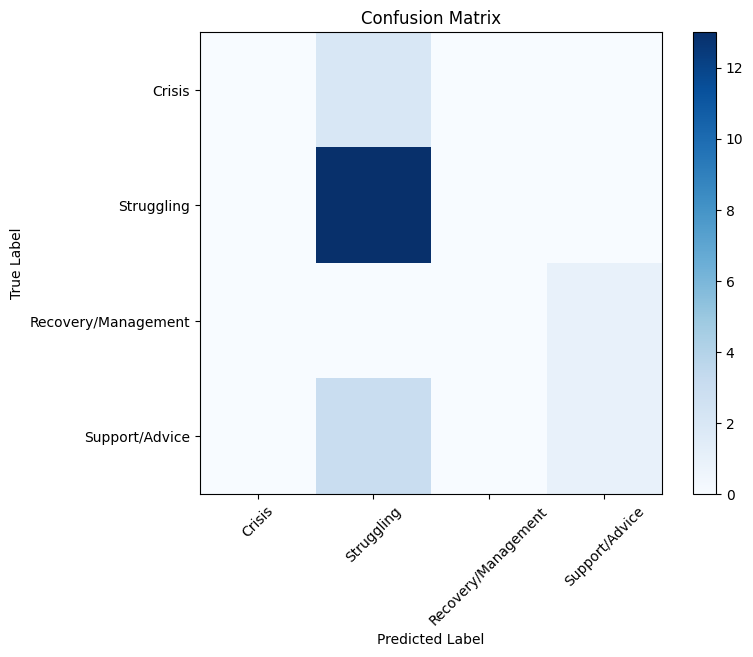

/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Classification Report:
                     precision    recall  f1-score   support

             Crisis       0.00      0.00      0.00         2
         Struggling       0.72      1.00      0.84        13
Recovery/Management       0.00      0.00      0.00         1
     Support/Advice       0.50      0.25      0.33         4

           accuracy                           0.70        20
          macro avg       0.31      0.31      0.29        20
       weighted avg       0.57      0.70      0.61        20



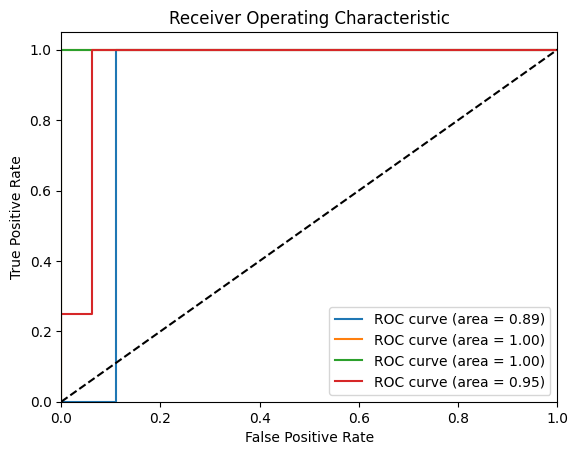

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Step 7: Inference
test_logits = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_logits.extend(logits.tolist())

# Convert logits to probabilities using softmax
test_probs = F.softmax(torch.tensor(test_logits), dim=1) # Use this
test_predictions = torch.argmax(test_probs, dim=1).tolist()

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels.csv', index=False)

# Step 8: Performance Evaluation
true_labels = test_data['label']

# Confusion Matrix
cm = confusion_matrix(true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(true_labels, test_predictions, target_names=label_mapping.keys())
print('Classification Report:')
print(report)

# ROC Curve and AUC for each class - Base this on 
num_classes = len(label_mapping)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Test 2: BERT Model 500 rows /w added slang dict

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('clean_annotated_posts.csv')

# Sample a smaller portion of data
sample_size = 500 
clean_annotated_posts = clean_annotated_posts.sample(sample_size)

# Convert the text labels to numeric labels
label_mapping = {
    'Crisis': 0,
    'Struggling': 1,
    'Recovery/Management': 2,
    'Support/Advice': 3
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Split the data into train, val, and test sets
train_data = clean_annotated_posts.sample(frac=0.6, random_state=42)
val_data = clean_annotated_posts.sample(frac=0.2, random_state=42)
test_data = clean_annotated_posts.sample(frac=0.2, random_state=42)

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label


max_length = 128
batch_size = 16

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars"
}


train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_loss / total_samples

    # Step 6: Evaluation
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

# Step 7: Inference
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels.csv', index=False)


2023-06-15 13:55:49.432956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if yo

Epoch 1/10 - Train Loss: 1.0352 - Val Accuracy: 0.6800
Epoch 2/10 - Train Loss: 1.0013 - Val Accuracy: 0.6800
Epoch 3/10 - Train Loss: 0.9983 - Val Accuracy: 0.6800
Epoch 4/10 - Train Loss: 0.9910 - Val Accuracy: 0.6800
Epoch 5/10 - Train Loss: 0.9645 - Val Accuracy: 0.6800
Epoch 6/10 - Train Loss: 0.9698 - Val Accuracy: 0.6800
Epoch 7/10 - Train Loss: 0.8342 - Val Accuracy: 0.7600
Epoch 8/10 - Train Loss: 0.7114 - Val Accuracy: 0.7500
Epoch 9/10 - Train Loss: 0.5725 - Val Accuracy: 0.9000
Epoch 10/10 - Train Loss: 0.3809 - Val Accuracy: 0.9200


In [3]:
# Save the trained model
model_save_path = 'best_bertmodel_500_w_slang.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


### Test 3: BERT Model on all 2000 Annotated Rows w/ Slang Dict

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('clean_annotated_posts.csv')


# Convert the text labels to numeric labels
label_mapping = {
    'Crisis': 0,
    'Struggling': 1,
    'Recovery/Management': 2,
    'Support/Advice': 3
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Split the data into train, val, and test sets
train_data = clean_annotated_posts.sample(frac=0.6, random_state=42)
val_data = clean_annotated_posts.sample(frac=0.2, random_state=42)
test_data = clean_annotated_posts.sample(frac=0.2, random_state=42)

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label


max_length = 128
batch_size = 16

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars"
}


train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_loss / total_samples

    # Step 6: Evaluation
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

# Step 7: Inference
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(2000).csv', index=False)


2023-06-15 15:58:48.148176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if yo

Epoch 1/10 - Train Loss: 1.0936 - Val Accuracy: 0.5877
Epoch 2/10 - Train Loss: 1.0196 - Val Accuracy: 0.6741
Epoch 3/10 - Train Loss: 0.9033 - Val Accuracy: 0.7160
Epoch 4/10 - Train Loss: 0.7690 - Val Accuracy: 0.7852
Epoch 5/10 - Train Loss: 0.6223 - Val Accuracy: 0.8395
Epoch 6/10 - Train Loss: 0.4165 - Val Accuracy: 0.9333
Epoch 7/10 - Train Loss: 0.2979 - Val Accuracy: 0.9556
Epoch 8/10 - Train Loss: 0.1724 - Val Accuracy: 0.9753
Epoch 9/10 - Train Loss: 0.1157 - Val Accuracy: 0.9951
Epoch 10/10 - Train Loss: 0.1234 - Val Accuracy: 0.9951


In [2]:
# Save the trained model
model_save_path = 'best_bertmodel_2000_w_slang_1.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


Data Leak occured, as 99% accuracy is unrealistic and likely means overgeneralisation and overfitting. Could be the way the train test split is set up? Going to retry using train_test_split from SKLearn.

### Test 4: BERT Model on all 2000 Annotated Rows w/ Slang Dict

In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('clean_annotated_posts.csv')

# Convert the text labels to numeric labels
label_mapping = {
    'Crisis': 0,
    'Struggling': 1,
    'Recovery/Management': 2,
    'Support/Advice': 3
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Create a training set and a testing set
train_data, test_data = train_test_split(clean_annotated_posts, test_size=0.2, random_state=42)

# Split the training set further into a smaller training set and a validation set
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label

max_length = 128
batch_size = 16


with open('slang_dict.pkl', 'rb') as file: # Load the slang dictionary from the pickle file
    slang_dict = pickle.load(file)

train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc='Training', leave=False):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_loss / total_samples

    # Step 6: Evaluation
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc='Validation', leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_predictions) 
    #Other metrics: is there a way to optimise based on a certain metric? Can I return the F1 to the score each epoch (as a call back)
    #Can I add another model such as an XGboost to this?

    tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

# Step 7: Inference
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(full).csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5 - Train Loss: 1.0740 - Val Accuracy: 0.6346
Epoch 1/5 - Train Loss: 1.0740 - Val Accuracy: 0.6346


Epochs:  40%|████      | 2/5 [1:35:14<2:11:53, 2637.96s/it]

Epoch 2/5 - Train Loss: 1.0546 - Val Accuracy: 0.6346
Epoch 2/5 - Train Loss: 1.0546 - Val Accuracy: 0.6346


Epochs:  60%|██████    | 3/5 [2:01:36<1:11:52, 2156.02s/it]

Epoch 3/5 - Train Loss: 1.0366 - Val Accuracy: 0.6346
Epoch 3/5 - Train Loss: 1.0366 - Val Accuracy: 0.6346


Epochs:  80%|████████  | 4/5 [2:26:38<31:37, 1897.92s/it]  

Epoch 4/5 - Train Loss: 1.0316 - Val Accuracy: 0.6346
Epoch 4/5 - Train Loss: 1.0316 - Val Accuracy: 0.6346


Epochs: 100%|██████████| 5/5 [2:51:39<00:00, 2059.93s/it]


Epoch 5/5 - Train Loss: 0.9815 - Val Accuracy: 0.6568
Epoch 5/5 - Train Loss: 0.9815 - Val Accuracy: 0.6568


In [8]:
# Save the trained model
model_save_path = 'best_bertmodel_2000_w_slang_5epoch.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


Currently most successful and realistic model result. Based on the imbalance of data (and a large number of struggling catergorisations), I am going to reannotate the data using 5 classes: Immediate Crisis, Mental Distress, Struggle/Challenge

### Trying Model with Subreddit Name Included within the Post Text

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('annotated_train_df/clean_annotated_posts_cat5.csv')

# Convert the text labels to numeric labels
label_mapping = {
    'Immediate Crisis': 0,
    'Mental Distress': 1,
    'Struggle/Challenge': 2,
    'Recovery/Management': 3,
    'Support/Advice': 4
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Create a training set and a testing set
train_data, test_data = train_test_split(clean_annotated_posts, test_size=0.2, random_state=42)

# Split the training set further into a smaller training set and a validation set
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        subreddit = self.data.iloc[index]['subreddit']  # Get the subreddit
        # Concatenate subreddit and text
        input_text = f"[{subreddit}] {text}"
        
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            input_text,  # Replace text with input_text
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label

max_length = 250
batch_size = 16

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars",
    "tf": "the fuck",
    "idk": "i dont know",
    "sh1t": "shit",
    "ed": "eating disorder",
    "pfp": "profile picture",
    "aspd": "antisocial personality disorder",
    "npd": "narcissistic personality disorder",
    "hpd": "histrionic personality disorder",
    "ppd": "paranoid personality disorder",
    "stpd": "schizotypal personality disorder",
    "pnd": "postnatal depression",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "ap": "attachment parenting",
    "bf": "breastfeeding",
    "cd": "cloth diapers",
    "ftm": "first time mum",
    "sahm": "stay at home mum",
    "todd": "the opposite of depression and despair",
    "nsr": "not a safe room (trigger warning necessary)",
    "potd": "post of the day",
    "cw": "content warning",
    "hw": "homework",
    "q&a": "questions and answers",
    "mod": "moderator",
    "sub": "subreddit",
    "repost": "reposting an earlier post",
    "oc": "original content",
    "pov": "point of view",
    "tia": "thanks in advance",
    "wfh": "work from home",
    "iso": "in search of",
    "lmk": "let me know",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "wysiwyg": "what you see is what you get",
    "rebt": "rational emotive behavior therapy",
    "mbct": "mindfulness-based cognitive therapy",
    "iapt": "improving access to psychological therapies",
    "ipt": "interpersonal therapy",
    "mbsr": "mindfulness-based stress reduction",
    "pet": "positron emission tomography",
    "mri": "magnetic resonance imaging",
    "fMRI": "functional magnetic resonance imaging",
    "sit": "stress inoculation training",
    "mecfs": "myalgic encephalomyelitis chronic fatigue syndrome",
    "fibro": "fibromyalgia",
    "cfs": "chronic fatigue syndrome",
    "ibs": "irritable bowel syndrome",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "pts": "post-traumatic stress",
    "c-ptsd": "complex post-traumatic stress disorder",
    "eds": "ehlers-danlos syndrome",
    "pcos": "polycystic ovary syndrome",
    "ibs": "irritable bowel syndrome",
    "hp": "health professional",
    "mhfa": "mental health first aid",
    "isp": "intensive suicide program",
    "acs": "acute crisis service",
    "rdoc": "research domain criteria",
    "nimh": "national institute of mental health",
    "who": "world health organization",
    "mha": "mental health america",
    "msw": "master of social work",
    "sad": "seasonal affective disorder",
    "psa": "public service announcement",
    "sv": "suicidal ideation",
    "sibs": "suicide in the back seat",
    "pmdd": "premenstrual dysphoric disorder",
    "ppd": "postpartum depression",
    "ppa": "postpartum anxiety",
    "trd": "treatment-resistant depression",
    "bfrb": "body-focused repetitive behavior",
    "csp": "compulsive skin picking",
    "cbt-i": "cognitive behavioral therapy for insomnia",
    "cmhc": "community mental health center",
    "camh": "centre for addiction and mental health",
    "bls": "basic life support",
    "bci": "brain-computer interface",
    "gis": "gender identity services",
    "mtf": "male to female",
    "ftm": "female to male",
    "aioc": "adults in online communities",
    "nc": "no contact",
    "lc": "low contact",
    "narc": "narcissist",
    "foc": "family of choice",
    "fog": "fear, obligation, guilt",
    "jade": "justify, argue, defend, explain",
    "faa": "fighting avoidance and apathy",
    "rle": "real life experience (transgender term)",
    "hrt": "hormone replacement therapy",
    "srs": "sex reassignment surgery",
    "gcs": "gender confirmation surgery",
    "ffs": "facial feminization surgery",
    "ba": "breast augmentation",
    "voc": "voice change or voice coaching",
    "diy": "do it yourself (refers to self-administered hormone therapy)",
    "yoyo inspector": "therapist",
    "ghosted": "stopped communicating without explanation",
    "high key": "really",
    "low key": "relaxed",
    "sus": "suspicious",
    "Spicy shower": "painful shower after self harm",
    "pyro styro": "self harm burn to dermis",
    "hobby surgeon": "person who self harms"
}


train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc='Training', leave=False):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_loss / total_samples

    # Step 6: Evaluation
    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc='Validation', leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_predictions) 
    #Other metrics: is there a way to optimise based on a certain metric? Can I return the F1 to the score each epoch (as a call back)
    #Can I add another model such as an XGboost to this?

    tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

# Step 7: Inference
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(full).csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5 - Train Loss: 1.4655 - Val Accuracy: 0.3900
Epoch 1/5 - Train Loss: 1.4655 - Val Accuracy: 0.3900


Epochs:  40%|████      | 2/5 [42:36<1:01:40, 1233.45s/it]

Epoch 2/5 - Train Loss: 1.3628 - Val Accuracy: 0.3650
Epoch 2/5 - Train Loss: 1.3628 - Val Accuracy: 0.3650


Epochs:  60%|██████    | 3/5 [59:10<37:29, 1124.54s/it]  

Epoch 3/5 - Train Loss: 1.2688 - Val Accuracy: 0.4250
Epoch 3/5 - Train Loss: 1.2688 - Val Accuracy: 0.4250


Epochs:  80%|████████  | 4/5 [1:15:57<17:57, 1077.88s/it]

Epoch 4/5 - Train Loss: 1.1679 - Val Accuracy: 0.4500
Epoch 4/5 - Train Loss: 1.1679 - Val Accuracy: 0.4500


Epochs: 100%|██████████| 5/5 [1:33:23<00:00, 1120.70s/it]


Epoch 5/5 - Train Loss: 0.9719 - Val Accuracy: 0.4425
Epoch 5/5 - Train Loss: 0.9719 - Val Accuracy: 0.4425


In [7]:
# Save the trained model
model_save_path = 'best_bertmodel_2000_w_slang_5class_5epoch.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


### BERT accuracy really low, I believe it is due to the learning rate and hyperparameter tuning, will be making adjustments for learning_rates = [3e-4, 1e-4, 5e-5, 3e-5], as learning rate of 0.01 is noted as being very high.
###### (as per: https://wandb.ai/jack-morris/david-vs-goliath/reports/Does-Model-Size-Matter-A-Comparison-of-BERT-and-DistilBERT--VmlldzoxMDUxNzU#4.-bert:-optimal-hyperparameters), 


# update weights
optim.zero_grad() <- gradients are zeroed out after this call
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
optim.step()

In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from itertools import product

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('/Users/brittanyharding/LHL-Projects/SM-suicide_detection/Data/annotated_train_df/clean_annotated_posts_cat5.csv')

# Convert the text labels to numeric labels
label_mapping = {
    'Immediate Crisis': 0,
    'Mental Distress': 1,
    'Struggle/Challenge': 2,
    'Recovery/Management': 3,
    'Support/Advice': 4
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Create a training set and a testing set
train_data, test_data = train_test_split(clean_annotated_posts, test_size=0.2, random_state=42)

# Split the training set further into a smaller training set and a validation set
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        subreddit = self.data.iloc[index]['subreddit']  # Get the subreddit
        # Concatenate subreddit and text
        input_text = f"[{subreddit}] {text}"
        
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label

max_length = 100

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars",
    "tf": "the fuck",
    "idk": "i dont know",
    "sh1t": "shit",
    "ed": "eating disorder",
    "pfp": "profile picture",
    "aspd": "antisocial personality disorder",
    "npd": "narcissistic personality disorder",
    "hpd": "histrionic personality disorder",
    "ppd": "paranoid personality disorder",
    "stpd": "schizotypal personality disorder",
    "pnd": "postnatal depression",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "ap": "attachment parenting",
    "bf": "breastfeeding",
    "cd": "cloth diapers",
    "ftm": "first time mum",
    "sahm": "stay at home mum",
    "todd": "the opposite of depression and despair",
    "nsr": "not a safe room (trigger warning necessary)",
    "potd": "post of the day",
    "cw": "content warning",
    "hw": "homework",
    "q&a": "questions and answers",
    "mod": "moderator",
    "sub": "subreddit",
    "repost": "reposting an earlier post",
    "oc": "original content",
    "pov": "point of view",
    "tia": "thanks in advance",
    "wfh": "work from home",
    "iso": "in search of",
    "lmk": "let me know",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "wysiwyg": "what you see is what you get",
    "rebt": "rational emotive behavior therapy",
    "mbct": "mindfulness-based cognitive therapy",
    "iapt": "improving access to psychological therapies",
    "ipt": "interpersonal therapy",
    "mbsr": "mindfulness-based stress reduction",
    "pet": "positron emission tomography",
    "mri": "magnetic resonance imaging",
    "fMRI": "functional magnetic resonance imaging",
    "sit": "stress inoculation training",
    "mecfs": "myalgic encephalomyelitis chronic fatigue syndrome",
    "fibro": "fibromyalgia",
    "cfs": "chronic fatigue syndrome",
    "ibs": "irritable bowel syndrome",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "pts": "post-traumatic stress",
    "c-ptsd": "complex post-traumatic stress disorder",
    "eds": "ehlers-danlos syndrome",
    "pcos": "polycystic ovary syndrome",
    "ibs": "irritable bowel syndrome",
    "hp": "health professional",
    "mhfa": "mental health first aid",
    "isp": "intensive suicide program",
    "acs": "acute crisis service",
    "rdoc": "research domain criteria",
    "nimh": "national institute of mental health",
    "who": "world health organization",
    "mha": "mental health america",
    "msw": "master of social work",
    "sad": "seasonal affective disorder",
    "psa": "public service announcement",
    "sv": "suicidal ideation",
    "sibs": "suicide in the back seat",
    "pmdd": "premenstrual dysphoric disorder",
    "ppd": "postpartum depression",
    "ppa": "postpartum anxiety",
    "trd": "treatment-resistant depression",
    "bfrb": "body-focused repetitive behavior",
    "csp": "compulsive skin picking",
    "cbt-i": "cognitive behavioral therapy for insomnia",
    "cmhc": "community mental health center",
    "camh": "centre for addiction and mental health",
    "bls": "basic life support",
    "bci": "brain-computer interface",
    "gis": "gender identity services",
    "mtf": "male to female",
    "ftm": "female to male",
    "aioc": "adults in online communities",
    "nc": "no contact",
    "lc": "low contact",
    "narc": "narcissist",
    "foc": "family of choice",
    "fog": "fear, obligation, guilt",
    "jade": "justify, argue, defend, explain",
    "faa": "fighting avoidance and apathy",
    "rle": "real life experience (transgender term)",
    "hrt": "hormone replacement therapy",
    "srs": "sex reassignment surgery",
    "gcs": "gender confirmation surgery",
    "ffs": "facial feminization surgery",
    "ba": "breast augmentation",
    "voc": "voice change or voice coaching",
    "diy": "do it yourself (refers to self-administered hormone therapy)",
    "yoyo inspector": "therapist",
    "ghosted": "stopped communicating without explanation",
    "high key": "really",
    "low key": "relaxed",
    "sus": "suspicious",
    "Spicy shower": "painful shower after self harm",
    "pyro styro": "self harm burn to dermis",
    "hobby surgeon": "person who self harms",
    "vsed": "voluntarily stopping eating and drinking"
}

train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
num_epochs = 20

# Define the hyperparameter options
batch_sizes = [64]
learning_rates = [1e-5]

# # Define the warm-up steps
# warmup_steps = int(len(train_dataloader) * num_epochs * WARMUP_PROPORTION)


# Perform grid search over hyperparameter combinations
for batch_size, learning_rate in product(batch_sizes, learning_rates):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        total_loss = 0
        total_samples = 0

        for batch in tqdm(train_dataloader, desc='Training', leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            loss.backward()
            optimizer.step()
            # # Change to this -> update weights -> avoid exploding gradient
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # optimizer.step()

        train_loss = total_loss / total_samples

        # Step 6: Evaluation
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc='Validation', leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.tolist())
                val_labels.extend(labels.tolist())

        val_accuracy = accuracy_score(val_labels, val_predictions) 
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    print(f'Batch Size: {batch_size}, Learning Rate: {learning_rate}')
    print(f'Final Val Accuracy: {val_accuracy:.4f}')

    # Compute and print the classification report
    val_classification_report = classification_report(val_labels, val_predictions)
    print('Validation Classification Report:')
    print(val_classification_report)
    print('---')

# Step 7: Inference
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(full).csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Updated Model on 2000 rows

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from itertools import product

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('/Users/brittanyharding/LHL-Projects/SM-suicide_detection/Data/annotated_train_df/clean_annotated_posts_cat5.csv')

# Convert the text labels to numeric labels
label_mapping = {
    'Immediate Crisis': 0,
    'Mental Distress': 1,
    'Struggle/Challenge': 2,
    'Recovery/Management': 3,
    'Support/Advice': 4
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Create a training set and a testing set
train_data, test_data = train_test_split(clean_annotated_posts, test_size=0.2, random_state=42)

# Split the training set further into a smaller training set and a validation set
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        subreddit = self.data.iloc[index]['subreddit']  # Get the subreddit
        # Concatenate subreddit and text
        input_text = f"[{subreddit}] {text}"
        
        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label

max_length = 100

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars",
    "tf": "the fuck",
    "idk": "i dont know",
    "sh1t": "shit",
    "ed": "eating disorder",
    "pfp": "profile picture",
    "aspd": "antisocial personality disorder",
    "npd": "narcissistic personality disorder",
    "hpd": "histrionic personality disorder",
    "ppd": "paranoid personality disorder",
    "stpd": "schizotypal personality disorder",
    "pnd": "postnatal depression",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "ap": "attachment parenting",
    "bf": "breastfeeding",
    "cd": "cloth diapers",
    "ftm": "first time mum",
    "sahm": "stay at home mum",
    "todd": "the opposite of depression and despair",
    "nsr": "not a safe room (trigger warning necessary)",
    "potd": "post of the day",
    "cw": "content warning",
    "hw": "homework",
    "q&a": "questions and answers",
    "mod": "moderator",
    "sub": "subreddit",
    "repost": "reposting an earlier post",
    "oc": "original content",
    "pov": "point of view",
    "tia": "thanks in advance",
    "wfh": "work from home",
    "iso": "in search of",
    "lmk": "let me know",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "wysiwyg": "what you see is what you get",
    "rebt": "rational emotive behavior therapy",
    "mbct": "mindfulness-based cognitive therapy",
    "iapt": "improving access to psychological therapies",
    "ipt": "interpersonal therapy",
    "mbsr": "mindfulness-based stress reduction",
    "pet": "positron emission tomography",
    "mri": "magnetic resonance imaging",
    "fMRI": "functional magnetic resonance imaging",
    "sit": "stress inoculation training",
    "mecfs": "myalgic encephalomyelitis chronic fatigue syndrome",
    "fibro": "fibromyalgia",
    "cfs": "chronic fatigue syndrome",
    "ibs": "irritable bowel syndrome",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "pts": "post-traumatic stress",
    "c-ptsd": "complex post-traumatic stress disorder",
    "eds": "ehlers-danlos syndrome",
    "pcos": "polycystic ovary syndrome",
    "ibs": "irritable bowel syndrome",
    "hp": "health professional",
    "mhfa": "mental health first aid",
    "isp": "intensive suicide program",
    "acs": "acute crisis service",
    "rdoc": "research domain criteria",
    "nimh": "national institute of mental health",
    "who": "world health organization",
    "mha": "mental health america",
    "msw": "master of social work",
    "sad": "seasonal affective disorder",
    "psa": "public service announcement",
    "sv": "suicidal ideation",
    "sibs": "suicide in the back seat",
    "pmdd": "premenstrual dysphoric disorder",
    "ppd": "postpartum depression",
    "ppa": "postpartum anxiety",
    "trd": "treatment-resistant depression",
    "bfrb": "body-focused repetitive behavior",
    "csp": "compulsive skin picking",
    "cbt-i": "cognitive behavioral therapy for insomnia",
    "cmhc": "community mental health center",
    "camh": "centre for addiction and mental health",
    "bls": "basic life support",
    "bci": "brain-computer interface",
    "gis": "gender identity services",
    "mtf": "male to female",
    "ftm": "female to male",
    "aioc": "adults in online communities",
    "nc": "no contact",
    "lc": "low contact",
    "narc": "narcissist",
    "foc": "family of choice",
    "fog": "fear, obligation, guilt",
    "jade": "justify, argue, defend, explain",
    "faa": "fighting avoidance and apathy",
    "rle": "real life experience (transgender term)",
    "hrt": "hormone replacement therapy",
    "srs": "sex reassignment surgery",
    "gcs": "gender confirmation surgery",
    "ffs": "facial feminization surgery",
    "ba": "breast augmentation",
    "voc": "voice change or voice coaching",
    "diy": "do it yourself (refers to self-administered hormone therapy)",
    "yoyo inspector": "therapist",
    "ghosted": "stopped communicating without explanation",
    "high key": "really",
    "low key": "relaxed",
    "sus": "suspicious",
    "Spicy shower": "painful shower after self harm",
    "pyro styro": "self harm burn to dermis",
    "hobby surgeon": "person who self harms",
    "vsed": "voluntarily stopping eating and drinking"
}

train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
num_epochs = 10
# Look at adding a

# Define the hyperparameter options
batch_sizes = [8, 16, 32, 64]
learning_rates = [3e-4, 1e-4, 5e-5, 3e-5]

# # Define the warm-up steps
# warmup_steps = int(len(train_dataloader) * num_epochs * WARMUP_PROPORTION)


# Perform grid search over hyperparameter combinations
for batch_size, learning_rate in product(batch_sizes, learning_rates):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        total_loss = 0
        total_samples = 0

        for batch in tqdm(train_dataloader, desc='Training', leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            loss.backward()
            optimizer.step()
            # # Change to this -> update weights -> avoid exploding gradient
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # optimizer.step()

        train_loss = total_loss / total_samples

        # Step 6: Evaluation
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc='Validation', leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.tolist())
                val_labels.extend(labels.tolist())

        val_accuracy = accuracy_score(val_labels, val_predictions) 
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    print(f'Batch Size: {batch_size}, Learning Rate: {learning_rate}')
    print(f'Final Val Accuracy: {val_accuracy:.4f}')

    # Compute and print the classification report
    val_classification_report = classification_report(val_labels, val_predictions)
    print('Validation Classification Report:')
    print(val_classification_report)
    print('---')

# Step 7: Inference
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(full).csv', index=False)

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from itertools import product

# Step 1: Data Preparation
clean_annotated_posts = pd.read_csv('/Users/brittanyharding/LHL-Projects/SM-suicide_detection/Data/annotated_train_df/clean_annotated_posts_cat5.csv')

# Convert the text labels to numeric labels
label_mapping = {
    'Immediate Crisis': 0,
    'Mental Distress': 1,
    'Struggle/Challenge': 2,
    'Recovery/Management': 3,
    'Support/Advice': 4
}

clean_annotated_posts['label'] = clean_annotated_posts['classification'].map(label_mapping)

# Create a training set and a testing set
train_data, test_data = train_test_split(clean_annotated_posts, test_size=0.1, random_state=42)

# Split the training set further into a smaller training set and a validation set
train_data, val_data = train_test_split(train_data, test_size=1/9, random_state=42)  # 1/9 x 0.9 = 0.1

# Step 2: Fine-tuning BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(clean_annotated_posts['label'].unique()))

# Step 3: Dataset Preparation
class PostDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, slang_dict):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.slang_dict = slang_dict

    def preprocess_text(self, text):
        # Replace slang words with their meanings
        for slang, meaning in self.slang_dict.items():
            text = text.replace(slang, meaning)
        return text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['tokenized_preprocessed_post']
        subreddit = self.data.iloc[index]['subreddit']  # Get the subreddit
        # Concatenate subreddit and text
        input_text = f"[{subreddit}] {text}"

        label = self.data.iloc[index]['label']
        encoded_input = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Convert labels to torch.long type
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label

max_length = 100

slang_dict = {
    "mh": "mental health",
    "adhd": "attention deficit hyperactivity disorder",
    "asd": "autism spectrum disorder",
    "bpd": "borderline personality disorder",
    "ocd": "obsessive-compulsive disorder",
    "ptsd": "post-traumatic stress disorder",
    "gad": "generalized anxiety disorder",
    "mdd": "major depressive disorder",
    "sad": "social anxiety disorder or seasonal affective disorder",
    "bd": "bipolar disorder",
    "dx": "diagnosis",
    "tx": "treatment",
    "rx": "prescription",
    "cbt": "cognitive behavioral therapy",
    "dbt": "dialectical behavior therapy",
    "emdr": "eye movement desensitization and reprocessing",
    "act": "acceptance and commitment therapy",
    "ssri": "selective serotonin reuptake inhibitor",
    "snri": "serotonin and norepinephrine reuptake inhibitor",
    "nd": "neurodivergent",
    "nt": "neurotypical",
    "dsm": "diagnostic and statistical manual of mental disorders",
    "stims": "self-stimulatory behavior",
    "stimming": "self-stimulatory behavior",
    "tw": "trigger warning",
    "bp": "bipolar",
    "apd": "antisocial personality disorder",
    "avpd": "avoidant personality disorder",
    "did": "dissociative identity disorder",
    "spd": "schizoid personality disorder or sensory processing disorder",
    "ed": "eating disorder",
    "an": "anorexia nervosa",
    "bn": "bulimia nervosa",
    "bed": "binge eating disorder",
    "osfed": "other specified feeding or eating disorder",
    "sh": "self harm",
    "si": "suicidal ideation",
    "iop": "intensive outpatient",
    "ip": "inpatient",
    "tms": "transcranial magnetic stimulation",
    "ect": "electroconvulsive therapy",
    "np": "nurse practitioner",
    "pa": "physician's assistant",
    "psyd": "doctor of psychology",
    "md": "medical doctor",
    "lcsw": "licensed clinical social worker",
    "lmft": "licensed marriage and family therapist",
    "lpcc": "licensed professional clinical counselor",
    "erp": "exposure and response prevention",
    "nos": "not otherwise specified",
    "pe": "prolonged exposure",
    "sa": "social anxiety",
    "meds": "medications",
    "dpdr": "depersonalization-derealization",
    "pdoc": "psychiatrist",
    "tdoc": "therapist",
    "brain fog": "difficulty thinking clearly",
    "grounding": "techniques used to help stay in the present moment",
    "disso": "dissociation",
    "mania": "manic episode",
    "hypo": "hypomania",
    "zaps": "brain zaps",
    "med change": "changing medications",
    "titrate": "gradually increase or decrease medication dose",
    "psych ward": "psychiatric ward",
    "5150": "involuntary psychiatric hold",
    "in crisis": "experiencing a mental health emergency",
    "meltdown": "emotional breakdown",
    "shutdown": "a response to stress or overwhelm often experienced by people with autism",
    "spiraling": "quickly worsening mental health symptoms",
    "flashbacks": "intrusive memories of a traumatic event",
    "grounding techniques": "methods used to bring oneself back into the present moment",
    "gaslighting": "manipulative behavior to make someone doubt their own experiences",
    "ghosting": "ending a relationship by suddenly and without explanation withdrawing from all communication",
    "breadcrumbing": "the act of sending out flirtatious, but non-committal messages in order to lure a romantic partner",
    "shed": "self-harmed",
    "op": "original poster",
    "tl;dr": "too long; didn't read",
    "dae": "does anyone else",
    "iirc": "if i remember correctly",
    "ftfy": "fixed that for you",
    "ama": "ask me anything",
    "amaa": "ask me almost anything",
    "iama": "i am a...",
    "cmv": "change my view",
    "lpt": "life pro tip",
    "eli5": "explain like i'm 5",
    "imo": "in my opinion",
    "imho": "in my honest opinion",
    "ymmv": "your mileage may vary",
    "so": "significant other",
    "ysk": "you should know",
    "psa": "public service announcement",
    "til": "today i learned",
    'nsfl': "not safe for life",
    'nsfw': "not safe for work",
    'wip': "work in progress",
    'ikyky': "if you know you know",
    'finna': "getting ready to do something",
    'med': "medication",
    'meds': "medications",
    'od d': "overdosed",
    'od': "overdose",
    'sm': "social media",
    'pci': "post-crisis intervention",
    'hr': "human resources",
    "cap": "lie",
    "no cap": "no lie",
    "lit": "amazing or exciting",
    "on fleek": "perfect or flawless",
    "flex": "showing off or bragging",
    "clout": "influence or popularity",
    "savage": "fierce or ruthless",
    "GOAT": "greatest of all time",
    "bae": "before anyone else",
    "chill": "calm down",
    "thirsty": "desperate for attention",
    "woke": "aware or knowledgeable",
    "AF": "as fuck (emphasizing something)",
    "squad": "group of friends",
    "hater": "person who dislikes or criticizes others",
    "flexin'": "showing off or boasting",
    "gig": "job or event",
    "shook": "surprised or shocked",
    "vibe": "atmosphere or feeling",
    "thicc": "curvy or voluptuous",
    "salty": "bitter or resentful",
    "basic": "unoriginal or mainstream",
    "extra": "over the top or excessive",
    "depressy": "depressed",
    "grippy sock vacation": "psychiatric care",
    "doom scrolling": "obsessively scrolling",
    "sewerslide": "suicide",
    "menty b": "mental breakdown",
    "unalive": "die",
    "i had pasta tonight": "having suicidal thoughts",
    "i finished my shampoo and conditioner at the same time": "having suicidal thoughts",
    "plug": "drug dealer",
    "420": "marijuana",
    "burnout": "heavy drug user",
    "clucking": "withdrawal",
    "cold turkey": "abrupt withdrawal",
    "cooker": "heavy drug user",
    "dial-a-doping": "drug delivery",
    "doc": "drug of choice",
    "faded": "intoxicated",
    "🍭": "drug user or drug supplier",
    "molly": "mdma",
    "pnp": "party and play",
    "snowflake": "cocaine or overly sensitive person",
    "turnt": "under influence",
    "zombie": "heavy drug user",
    "kys": "kill yourself",
    "kms": "kill myself",
    "merked": "very drunk or beaten up",
    "#sue": "suicide",
    "dirl": "die in real life",
    "#ana": "anorexia",
    "#deb": "depression",
    "cat scratches": "superficial self-harm cuts",
    "styros": "self-harm cuts to dermis",
    "beans": "self-harm cuts to fat layer",
    "x": "ecstasy",
    "xan": "xanax",
    "back-to-school necklace": "noose reference",
    "#cuts": "self-harm discussion",
    "#cu46": "sexual meet-up",
    "#ednos": "unspecified eating disorder",
    "#kush": "marijuana discussion",
    "#mias": "bulimia discussion",
    "#secretsociety123": "self-harm community",
    "#selfharmmm": "self-harm discussion",
    "#svv": "self-harm discussion",
    "#tina": "crystal meth",
    "#thinsp": "unhealthy weight loss promotion",
    "#proana": "pro-anorexia promotion",
    "#promia": "pro-bulimia promotion",
    "yeet": "self-harm - cutting",
    "yeets": "self-harm wounds/scars (recent)",
    "yeeting": "cutting",
    "final yeet": "suicide attempt",
    "slicey bois": "razors",
    "barcode": "cluster of self-harm wounds/scars",
    "tf": "the fuck",
    "idk": "i dont know",
    "sh1t": "shit",
    "ed": "eating disorder",
    "pfp": "profile picture",
    "aspd": "antisocial personality disorder",
    "npd": "narcissistic personality disorder",
    "hpd": "histrionic personality disorder",
    "ppd": "paranoid personality disorder",
    "stpd": "schizotypal personality disorder",
    "pnd": "postnatal depression",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "ap": "attachment parenting",
    "bf": "breastfeeding",
    "cd": "cloth diapers",
    "ftm": "first time mum",
    "sahm": "stay at home mum",
    "todd": "the opposite of depression and despair",
    "nsr": "not a safe room (trigger warning necessary)",
    "potd": "post of the day",
    "cw": "content warning",
    "hw": "homework",
    "q&a": "questions and answers",
    "mod": "moderator",
    "sub": "subreddit",
    "repost": "reposting an earlier post",
    "oc": "original content",
    "pov": "point of view",
    "tia": "thanks in advance",
    "wfh": "work from home",
    "iso": "in search of",
    "lmk": "let me know",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "wysiwyg": "what you see is what you get",
    "rebt": "rational emotive behavior therapy",
    "mbct": "mindfulness-based cognitive therapy",
    "iapt": "improving access to psychological therapies",
    "ipt": "interpersonal therapy",
    "mbsr": "mindfulness-based stress reduction",
    "pet": "positron emission tomography",
    "mri": "magnetic resonance imaging",
    "fMRI": "functional magnetic resonance imaging",
    "sit": "stress inoculation training",
    "mecfs": "myalgic encephalomyelitis chronic fatigue syndrome",
    "fibro": "fibromyalgia",
    "cfs": "chronic fatigue syndrome",
    "ibs": "irritable bowel syndrome",
    "pmdd": "premenstrual dysphoric disorder",
    "pms": "premenstrual syndrome",
    "pts": "post-traumatic stress",
    "c-ptsd": "complex post-traumatic stress disorder",
    "eds": "ehlers-danlos syndrome",
    "pcos": "polycystic ovary syndrome",
    "ibs": "irritable bowel syndrome",
    "hp": "health professional",
    "mhfa": "mental health first aid",
    "isp": "intensive suicide program",
    "acs": "acute crisis service",
    "rdoc": "research domain criteria",
    "nimh": "national institute of mental health",
    "who": "world health organization",
    "mha": "mental health america",
    "msw": "master of social work",
    "sad": "seasonal affective disorder",
    "psa": "public service announcement",
    "sv": "suicidal ideation",
    "sibs": "suicide in the back seat",
    "pmdd": "premenstrual dysphoric disorder",
    "ppd": "postpartum depression",
    "ppa": "postpartum anxiety",
    "trd": "treatment-resistant depression",
    "bfrb": "body-focused repetitive behavior",
    "csp": "compulsive skin picking",
    "cbt-i": "cognitive behavioral therapy for insomnia",
    "cmhc": "community mental health center",
    "camh": "centre for addiction and mental health",
    "bls": "basic life support",
    "bci": "brain-computer interface",
    "gis": "gender identity services",
    "mtf": "male to female",
    "ftm": "female to male",
    "aioc": "adults in online communities",
    "nc": "no contact",
    "lc": "low contact",
    "narc": "narcissist",
    "foc": "family of choice",
    "fog": "fear, obligation, guilt",
    "jade": "justify, argue, defend, explain",
    "faa": "fighting avoidance and apathy",
    "rle": "real life experience (transgender term)",
    "hrt": "hormone replacement therapy",
    "srs": "sex reassignment surgery",
    "gcs": "gender confirmation surgery",
    "ffs": "facial feminization surgery",
    "ba": "breast augmentation",
    "voc": "voice change or voice coaching",
    "diy": "do it yourself (refers to self-administered hormone therapy)",
    "yoyo inspector": "therapist",
    "ghosted": "stopped communicating without explanation",
    "high key": "really",
    "low key": "relaxed",
    "sus": "suspicious",
    "Spicy shower": "painful shower after self harm",
    "pyro styro": "self harm burn to dermis",
    "hobby surgeon": "person who self harms"
}

train_dataset = PostDataset(train_data, tokenizer, max_length, slang_dict)
val_dataset = PostDataset(val_data, tokenizer, max_length, slang_dict)
test_dataset = PostDataset(test_data, tokenizer, max_length, slang_dict)

# Step 4: Model Architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 5: Training
num_epochs = 10

# Define the hyperparameter options
batch_sizes = [64]
learning_rates = [1e-5]

# Perform grid search over hyperparameter combinations
for batch_size, learning_rate in product(batch_sizes, learning_rates):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        total_loss = 0
        total_samples = 0

        for batch in tqdm(train_dataloader, desc='Training', leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            loss.backward()
            optimizer.step()

        train_loss = total_loss / total_samples

        # Step 6: Evaluation
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc='Validation', leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.tolist())
                val_labels.extend(labels.tolist())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}')

    print(f'Batch Size: {batch_size}, Learning Rate: {learning_rate}')
    print(f'Final Val Accuracy: {val_accuracy:.4f}')

    # Compute and print the classification report
    val_classification_report = classification_report(val_labels, val_predictions)
    print('Validation Classification Report:')
    print(val_classification_report)
    print('---')

# Step 7: Inference
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.tolist())

# Create a new DataFrame for inferred labels
inferred_labels = pd.DataFrame({'post': test_data['post'], 'inferred_label': test_predictions})
inferred_labels.to_csv('inferred_labels(full).csv', index=False)


2023-06-21 06:06:03.995038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if yo

Epoch 1/10 - Train Loss: 1.5390 - Val Accuracy: 0.4250


Epochs:  20%|██        | 2/10 [42:06<2:48:19, 1262.46s/it]

Epoch 2/10 - Train Loss: 1.4827 - Val Accuracy: 0.4200


Epochs:  30%|███       | 3/10 [1:01:25<2:21:45, 1215.11s/it]

Epoch 3/10 - Train Loss: 1.4572 - Val Accuracy: 0.4200


Epochs:  40%|████      | 4/10 [1:20:32<1:58:49, 1188.17s/it]

Epoch 4/10 - Train Loss: 1.4102 - Val Accuracy: 0.4400


Epochs:  50%|█████     | 5/10 [1:39:41<1:37:50, 1174.17s/it]

Epoch 5/10 - Train Loss: 1.3684 - Val Accuracy: 0.4850


Epochs:  60%|██████    | 6/10 [1:59:06<1:18:03, 1170.82s/it]

Epoch 6/10 - Train Loss: 1.3208 - Val Accuracy: 0.4400


Epochs:  70%|███████   | 7/10 [2:18:00<57:56, 1158.78s/it]  

Epoch 7/10 - Train Loss: 1.2917 - Val Accuracy: 0.4850


Epochs:  80%|████████  | 8/10 [2:36:36<38:10, 1145.36s/it]

Epoch 8/10 - Train Loss: 1.2413 - Val Accuracy: 0.5000


Epochs:  90%|█████████ | 9/10 [2:55:31<19:01, 1141.98s/it]

Epoch 9/10 - Train Loss: 1.1650 - Val Accuracy: 0.5050


Epochs: 100%|██████████| 10/10 [3:14:23<00:00, 1166.40s/it]
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/10 - Train Loss: 1.0811 - Val Accuracy: 0.5150
Batch Size: 64, Learning Rate: 1e-05
Final Val Accuracy: 0.5150


/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        22
           1       0.33      0.09      0.15        43
           2       0.53      0.78      0.63        77
           3       0.00      0.00      0.00        15
           4       0.53      0.67      0.59        43

    accuracy                           0.52       200
   macro avg       0.38      0.40      0.37       200
weighted avg       0.44      0.52      0.45       200

---


In [2]:
# Save the trained model
model_save_path = 'currentbest_bertmodel_2000_w_slang_5class_5epoch.pth'
torch.save(model.state_dict(), model_save_path)
print("Trained model saved successfully.")

Trained model saved successfully.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

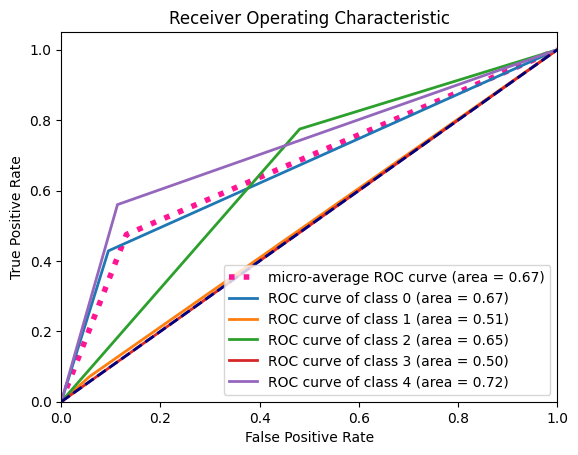

In [12]:
# Load the saved model
model_save_path = 'currentbest_bertmodel_2000_w_slang_5class_5epoch.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Apply the model to the test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
probs = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply softmax to obtain probabilities
        batch_probs = torch.nn.functional.softmax(logits, dim=1)
        probs.append(batch_probs.cpu().numpy())

        true_labels.extend(labels.numpy())

probs = np.concatenate(probs)
true_labels = np.array(true_labels)

# Binarize the true labels and predicted probabilities
true_labels_binary = label_binarize(true_labels, classes=np.arange(num_classes))
probs_binary = label_binarize(np.argmax(probs, axis=1), classes=np.arange(num_classes))

# Compute the false positive rate (FPR) and true positive rate (TPR) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binary[:, i], probs_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binary.ravel(), probs_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [14]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report

# Step 3: Load the saved model
model_path = 'currentbest_bertmodel_2000_w_slang_5class_5epoch.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.load_state_dict(torch.load(model_path))

# Step 4: Inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

predictions = []
probabilities = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_probabilities = torch.softmax(logits, dim=1)

        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.tolist())
        probabilities.extend(batch_probabilities.tolist())

# Calculate the percentage of cases predicted with a certain level of certainty
certainty_threshold = 0.99
predicted_labels = torch.tensor(predictions)
predicted_probabilities = torch.tensor(probabilities)

above_threshold = (predicted_probabilities.max(dim=1).values >= certainty_threshold)
percentage_of_cases = (above_threshold.sum().item() / len(above_threshold)) * 100

print(f"Percentage of cases predicted with at least {certainty_threshold*100}% certainty: {percentage_of_cases}%")

# Compute and print the classification report
test_labels = test_data['label']
test_classification_report = classification_report(test_labels, predicted_labels)
print('Test Classification Report:')
print(test_classification_report)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Percentage of cases predicted with at least 99.0% certainty: 0.0%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.43      0.38        21
           1       0.25      0.07      0.11        42
           2       0.47      0.77      0.59        71
           3       0.00      0.00      0.00        16
           4       0.62      0.56      0.59        50

    accuracy                           0.48       200
   macro avg       0.34      0.37      0.33       200
weighted avg       0.41      0.47      0.42       200



/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyharding/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

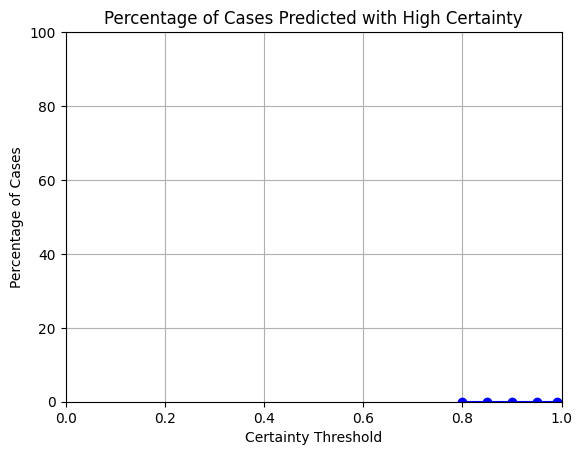

In [18]:
import matplotlib.pyplot as plt

# Calculate the percentage of cases predicted with a certain level of certainty
certainty_threshold = 0.99
above_threshold = (predicted_probabilities.max(dim=1).values >= certainty_threshold)
percentage_of_cases = (above_threshold.sum().item() / len(above_threshold)) * 100

# Create a scatter plot or line plot
thresholds = [certainty_threshold]
percentages = [percentage_of_cases]

plt.plot(thresholds, percentages, marker='o')
plt.xlabel('Certainty Threshold')
plt.ylabel('Percentage of Cases')
plt.title('Percentage of Cases Predicted with High Certainty')
plt.xlim([0, 1])  # Set the x-axis limit from 0 to 1
plt.ylim([0, 100])  # Set the y-axis limit from 0 to 100
plt.grid(True)  # Add grid lines
plt.show()


### Pseudo-Labelling

##### Assign pseudo-labels based on a threshold value for predicted probabilities or logits.
- If the maximum predicted probability or logits for a sample exceeds the threshold, assign the corresponding label. Otherwise, mark it as unlabeled.
- This method can be effective in scenarios where you want to focus on confident predictions and minimize the influence of uncertain or ambiguous samples.

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the unlabelled data
nonannotated_test_df = pd.read_csv('clean_non_annotated_test_df.csv')

# Load the trained model
model_path = 'bert_sample_sequence_classification_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.load_state_dict(torch.load(model_path))
model.eval()

# Set the threshold value for pseudo-labeling
threshold = 0.9

# List to store pseudo-labels
pseudo_labels = []

# Iterate over the unlabelled data and generate pseudo-labels
for index, row in non_annotated_test_df.iterrows():
    text = row['text']
    encoded_input = tokenizer.encode_plus(text, add_special_tokens=True, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    input_ids = encoded_input['input_ids'].squeeze()
    attention_mask = encoded_input['attention_mask'].squeeze()

    with torch.no_grad():
        output = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        logits = output.logits
        probabilities = torch.softmax(logits, dim=1)
        max_prob, predicted_label = torch.max(probabilities, dim=1)

    if max_prob.item() > threshold:
        pseudo_labels.append(predicted_label.item())
    else:
        pseudo_labels.append(-1)  # Use -1 for unlabeled samples

# Add pseudo-labels to the non_annotated_test_df DataFrame
non_annotated_test_df['pseudo_label'] = pseudo_labels

# Save the updated DataFrame with pseudo-labels
non_annotated_test_df.to_csv('non_annotated_test_df_with_pseudo_labels.csv', index=False)

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import ipywidgets as widgets
from IPython.display import display

# Load the unlabelled data
non_annotated_test_df = pd.read_csv('clean_non_annotated_test_df.csv')

# Load the DataFrame with pseudo-labels
data_with_pseudo_labels = pd.read_csv('non_annotated_test_df_with_pseudo_labels.csv')

# Filter the DataFrame to include only rows where pseudo_label is -1
data_with_pseudo_labels = data_with_pseudo_labels[data_with_pseudo_labels['pseudo_label'] == -1]

def on_button_clicked(b):
    # This function will be triggered when the 'Next' button is clicked
    global current_index
    current_example = data_with_pseudo_labels.iloc[current_index]
    current_text = current_example['text']
    text_area.value = current_text
    label_dropdown.value = None
    current_index += 1

def on_submit_button_clicked(b):
    # This function will be triggered when the 'Submit' button is clicked
    current_label = label_dropdown.value
    data_with_pseudo_labels.loc[current_index-1, 'pseudo_label'] = current_label
    # Save after each annotation to prevent data loss
    data_with_pseudo_labels.to_csv('non_annotated_test_df_with_manual_labels.csv', index=False)

text_area = widgets.Textarea()
label_dropdown = widgets.Dropdown(options=['Crisis', 'Struggling', 'Recovery/Management', 'Support/Advice'])
next_button = widgets.Button(description='Next')
submit_button = widgets.Button(description='Submit')
next_button.on_click(on_button_clicked)
submit_button.on_click(on_submit_button_clicked)
current_index = 0

display(text_area, label_dropdown, next_button, submit_button)


### Merge together clean_annotated_posts and newly_annotated_data_one

In [ ]:
# Load the original annotated dataset
clean_annotated_posts = pd.read_csv('clean_annotated_posts.csv')

# Load the new dataset with manual labels
newly_annotated_posts_one = pd.read_csv('newly_annotated_data_one.csv')

# Merge the datasets
full_annotated_posts_one = pd.concat([clean_annotated_posts, newly_annotated_posts_one])

# Save the full dataset
full_annotated_posts_one.to_csv('full_annotated_posts_one.csv', index=False)

### Visualise BERT Model with Graph Viz

In [20]:
import graphviz

# Create a new Graph object
graph = graphviz.Digraph(graph_attr={'size': '12,8', 'rankdir': 'LR', 'nodesep': '0.3'})

# Create subgraph for 'Data Preparation' and 'Fine-tuning BERT'
with graph.subgraph() as sg1:
    sg1.attr(rank='same')
    sg1.node('data_prep', 'Data Preparation', style='filled', fillcolor='#7FB3D5')
    sg1.node('fine_tuning', 'Fine-tuning BERT', style='filled', fillcolor='#7FB3D5')

# Create subgraph for 'Dataset Preparation' and 'Model Architecture'
with graph.subgraph() as sg2:
    sg2.attr(rank='same')
    sg2.node('dataset_prep', 'Dataset Preparation', style='filled', fillcolor='#A9D18E')
    sg2.node('model_arch', 'Model Architecture', style='filled', fillcolor='#A9D18E')

# Create subgraph for 'Training', 'Loop over each Epoch', and 'Forward Pass & Compute Loss'
with graph.subgraph() as sg3:
    sg3.attr(rank='same')
    sg3.node('training', 'Training', style='filled', fillcolor='#FABF8F')
    sg3.node('loop_epochs', 'Loop over each Epoch', style='filled', fillcolor='#FABF8F')
    sg3.node('forward_pass', 'Forward Pass & Compute Loss', style='filled', fillcolor='#FABF8F')

# Create subgraph for 'Backpropagation & Update Weights', 'Evaluation (Validation)', and 'Compute Metrics'
with graph.subgraph() as sg4:
    sg4.attr(rank='same')
    sg4.node('backprop', 'Backpropagation & Update Weights', style='filled', fillcolor='#FDD3C5')
    sg4.node('evaluation', 'Evaluation (Validation)', style='filled', fillcolor='#FDD3C5')
    sg4.node('compute_metrics', 'Compute Metrics', style='filled', fillcolor='#FDD3C5')
    sg4.node('end_epoch', 'End of Epoch', style='filled', fillcolor='#FDD3C5')

# Create subgraph for 'Check for Convergence', 'End of Training', and 'Evaluation (Testing)'
with graph.subgraph() as sg5:
    sg5.attr(rank='same')
    sg5.node('check_convergence', 'Check for Convergence', style='filled', fillcolor='#F8CBAD')
    sg5.node('end_training', 'End of Training', style='filled', fillcolor='#F8CBAD')
    sg5.node('testing', 'Evaluation (Testing)', style='filled', fillcolor='#F8CBAD')

# Add nodes to the graph
graph.node('start', 'Start', style='filled', fillcolor='#B9CDE5')
graph.node('end', 'End', style='filled', fillcolor='#B9CDE5')

# Add edges to connect the nodes
graph.edge('start', 'data_prep')
graph.edge('data_prep', 'fine_tuning')
graph.edge('fine_tuning', 'dataset_prep')
graph.edge('dataset_prep', 'model_arch')
graph.edge('model_arch', 'training', len='1.2')
graph.edge('training', 'loop_epochs')
graph.edge('loop_epochs', 'forward_pass')
graph.edge('forward_pass', 'backprop')
graph.edge('backprop', 'evaluation')
graph.edge('evaluation', 'compute_metrics')
graph.edge('compute_metrics', 'end_epoch')
graph.edge('end_epoch', 'check_convergence', len='1.2')
graph.edge('check_convergence', 'forward_pass')
graph.edge('check_convergence', 'end_training')
graph.edge('end_training', 'testing')
graph.edge('testing', 'end')

# Render and save the graph as an image file
graph.render('flowchart', format='png')

'flowchart.png'

### Visualisation for future Growth:

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Starting accuracy and row count
accuracy = 54.97
row_count = 3000

# Lists to store accuracy and row count values for the graph
accuracy_values = [accuracy]
row_count_values = [row_count]

# Forecasting improvement every 1000 rows until 75% accuracy is reached
with tqdm(total=74) as pbar:
    while accuracy < 75:
        improvement_per_500_rows = (75 - accuracy) / 500
        accuracy += improvement_per_500_rows
        row_count += 500
        accuracy_values.append(accuracy)
        row_count_values.append(row_count)
        pbar.update(improvement_per_500_rows)

# Plotting the graph
plt.plot(row_count_values, accuracy_values, marker='o')

# Adding labels and title
plt.xlabel('Number of Rows')
plt.ylabel('Accuracy')
plt.title('Forecasted Accuracy vs. Number of Rows')

# Displaying the graph
plt.show()


 27%|██▋       | 20.030003593809084/74 [14:57<40:17, 44.79s/it] 
